**this notebook runs with Weekly_2022_40 pipeline**

checking the version:

In [1]:
! echo $IMAGE_DESCRIPTION

Weekly 2022_40


---
---

## Construction of custom coadd using the visits with mean PSF size <= given value

In [2]:
import time, getpass
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

from pandas.testing import assert_frame_equal
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.time import Time

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
afwDisplay.setDefaultBackend('matplotlib')
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius
from lsst.afw.cameraGeom import utils as cgUtils
from lsst.afw.cameraGeom import FIELD_ANGLE, FOCAL_PLANE, PIXELS
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom
from lsst.daf.butler import Butler, DatasetType, CollectionType # access to LSST data products
import lsst.daf.base as dafBase
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst.cameraTransforms import ampPixelToCcdPixel

# lsst packages for executing pipeline tasks
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

# To ignore some kinds of warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
repo = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(repo, collections=collection)

visitTableRef = list(butler.registry.queryDatasets('visitTable'))
visitTable = butler.get(visitTableRef[0])

ccdTableRef = list(butler.registry.queryDatasets('ccdVisitTable'))
ccdTable = butler.get(ccdTableRef[0])

## Give coordinates, band, PSF size cut value

In [4]:
my_ra_deg = 55.745834
my_dec_deg = -32.269167
band = 'g'
psfSigma_cut = 2.0

In [5]:
# selecting the patch and tract
my_spherePoint = geom.SpherePoint(my_ra_deg*geom.degrees, my_dec_deg*geom.degrees)
skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
#print('My tract and patch: ', my_tract, my_patch)

In [6]:
# getting the list of visits to construct the default coadd
my_dataId = {'band': band, 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)
my_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()

del my_deepCoadd
#len(my_coadd_inputs.visits['id'])

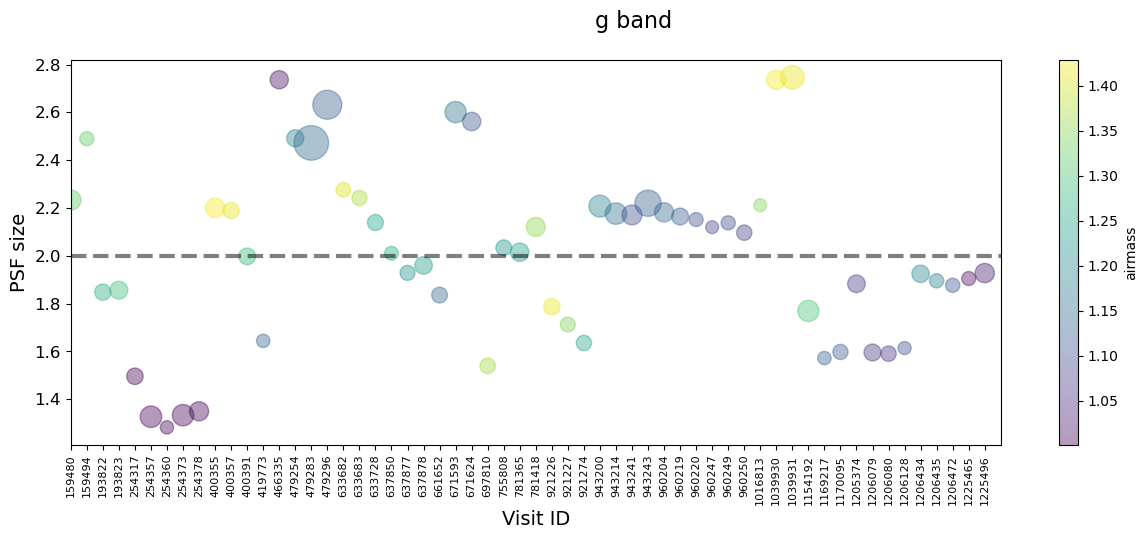

In [6]:
visit_list = my_coadd_inputs.visits['id']

dataset = {}
n_visits = len(visit_list)
xticklabels =[]
metrics = np.empty((0,6), float)

for i,v in enumerate(visit_list[0:n_visits]):
    try:
        dataId = {'visit':v,'detector': 0} 
        xticklabels.append(v)
        # values from ccd table
        psfSigma_mean = ccdTable['psfSigma'][ccdTable['visitId'] == v].mean()
        seeing_mean = ccdTable['seeing'][ccdTable['visitId'] == v].mean()
        psfSigma_std = ccdTable['psfSigma'][ccdTable['visitId'] == v].std()
        seeing_std = ccdTable['seeing'][ccdTable['visitId'] == v].std()
        airmass = visitTable['airmass'][visitTable['visit'] == v]
        metrics = np.append(metrics, np.array([[v, airmass, psfSigma_mean, psfSigma_std, seeing_mean, seeing_std]]), axis=0)
        
    except:
        pass

df_metrics = pd.DataFrame(data= metrics, columns = ['visit_id', 'airmass', 'psfSigma_mean', 'psfSigma_std', 'seeing_mean', 'seeing_std'])
df_metrics['visit_id'] = df_metrics['visit_id'].astype('int')
df_metrics['psfSigma_std'] = df_metrics['psfSigma_std'].astype('float')

if band in 'ugz': size_visit = 8
else: size_visit = 5
    
fig, ax = plt.subplots(figsize=(15, 5))
sc = ax.scatter(range(len(df_metrics)), df_metrics['psfSigma_mean'], s = df_metrics['psfSigma_std']*20000, c = df_metrics['airmass'], cmap = 'viridis', alpha=0.4)
ax.set_xticks(range(len(df_metrics)))
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=size_visit)
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_xlabel('Visit ID', fontsize=14)
ax.set_ylabel('PSF size', fontsize=14)
ax.set_xlim(0,len(df_metrics))
ax.axhline(y = psfSigma_cut, lw=3, ls='--', color='k', alpha=0.5)
plt.colorbar(sc, ax = ax, label='airmass')
fig.suptitle(band + " band", fontsize=16);


### Select the visits to construct the coadd

In [7]:
visits_selected = df_metrics['visit_id'][df_metrics['psfSigma_mean'] <= psfSigma_cut]
len(visits_selected)

28

## Custom coadd construction

In [8]:
my_visits_tupleString = "("+",".join(visits_selected.astype(str))+")"
print(my_visits_tupleString)

(193822,193823,254317,254357,254360,254373,254378,400391,419773,637877,637878,661652,697810,921226,921227,921274,1154192,1169217,1170095,1205374,1206079,1206080,1206128,1206434,1206435,1206472,1225465,1225496)


In [9]:
## list all the collections under 'kalamo'
#!butler query-collections dp02 --chains=tree u/kalamo/*

In [9]:
# Name a new butler collection for the output
my_username = getpass.getuser()
my_outputCollection = 'u/'+my_username+'/custom_coadd_' + band + 'band_psf'+str(psfSigma_cut)
#print('Name of new butler collection for my output: ', my_outputCollection)

In [10]:
my_outputCollection

'u/kalamo/custom_coadd_gband_psf2.0'

In [12]:
del butler, my_coadd_inputs

In [13]:
# set up the butler for the new collection
simpleButler = SimplePipelineExecutor.prep_butler('dp02', 
                                                  inputs=['2.2i/runs/DP0.2'], 
                                                  output=my_outputCollection)

simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/kalamo/custom_coadd_gband_psf2.0/20230818T002340Z', '2.2i/runs/DP0.2'))

In [14]:
# pipeline with the makeWarp and assembleCoadd tasks

In [15]:
## selection of makeWarp and assembleCoadd tasks
#assembleCoaddPipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml#makeWarp,assembleCoadd') 

#from latest version
assembleCoaddPipeline = Pipeline.from_uri('$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml#makeWarp,assembleCoadd') 

In [16]:
# configuration
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)
assembleCoaddPipeline.addConfigOverride('makeWarp', 'connections.visitSummary', "visitSummary")

In [17]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

In [19]:
## RUN the pipeline

spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

In [21]:
%time
quanta = spe.run()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs


## Display of default and custom coadds

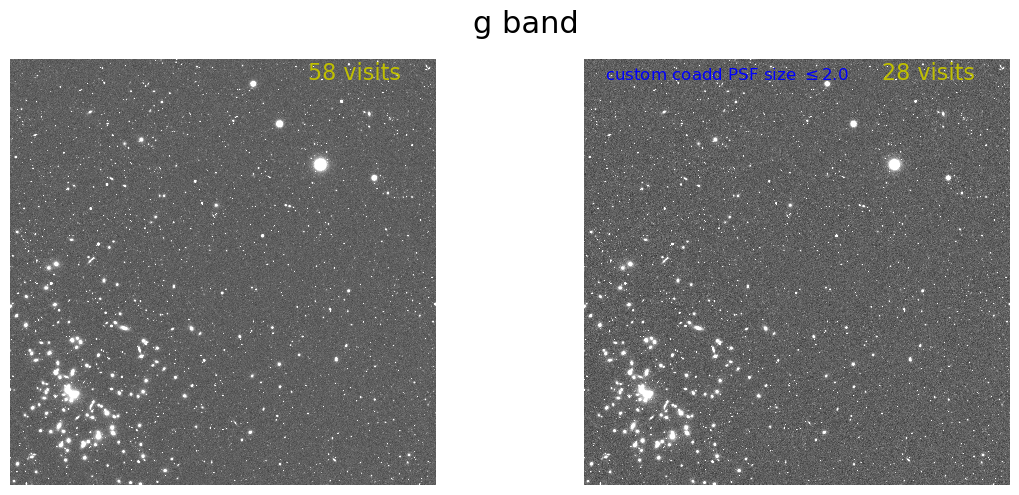

In [31]:
config1 = 'dp02'
collection1 = '2.2i/runs/DP0.2'
butler1 = Butler(config1, collections=collection1)
my_dataId1 = {'band': band, 'tract': my_tract, 'patch': my_patch}

config2 = "dp02"
collection2 = my_outputCollection
butler2 = Butler(config2, collections=collection2)
my_dataId2 = {'band': band, 'tract': my_tract, 'patch': my_patch}

allVisits_deepCoadd = butler1.get('deepCoadd', dataId=my_dataId1)
PSF_lt2_deepCoadd = butler2.get('deepCoadd', dataId=my_dataId2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(band + " band", fontsize=22)

plt.sca(ax[0])  
display1 = afwDisplay.Display(frame=fig) 
display1.scale('linear', min=-0.3, max=0.5)
#display1.scale('asinh', 'zscale')
display1.mtv(allVisits_deepCoadd.image)
display1.show_colorbar(False)
ax[0].text(0.7, 0.95, str(len(visit_list)) + " visits", color = 'y', fontsize=16, transform=ax[0].transAxes)
ax[0].axis('off')

plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', min=-0.3, max=0.5)
display2.mtv(PSF_lt2_deepCoadd.image)
display2.show_colorbar(False)
ax[1].text(0.7, 0.95, str(len(visits_selected)) + " visits", color = 'y', fontsize=16, transform=ax[1].transAxes)
ax[1].text(0.05, 0.95, r"custom coadd PSF size $\leq$" + str(psfSigma_cut), color = 'b', fontsize=12, transform=ax[1].transAxes)


ax[1].axis('off')
plt.tight_layout()
plt.show()


In [13]:

config2 = "dp02"
collection2 = my_outputCollection
butler2 = Butler(config2, collections=collection2)
my_dataId2 = {'band': band, 'tract': my_tract, 'patch': my_patch}


## Image characterization (detection, measurement and PSF construction)

In [14]:
tap_service = get_tap_service()

In [15]:
my_deepCoadd = butler2.get('deepCoadd', dataId=my_dataId2)
my_deepCoadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()
my_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
193822,11900,7900,16099,12099,15887257,33.34884045316235,g_sim_1.4
193823,11900,7900,16099,12099,13525109,33.07311333617513,g_sim_1.4
254317,11900,7900,16099,12099,9352179,36.740834704628355,g_sim_1.4
254357,11900,7900,16099,12099,15862748,36.85013413165563,g_sim_1.4
254360,11900,7900,16099,12099,15820169,36.85044823224245,g_sim_1.4
254373,11900,7900,16099,12099,16260477,36.66089162689194,g_sim_1.4
254378,11900,7900,16099,12099,15637571,36.97855729521804,g_sim_1.4
400391,11900,7900,16099,12099,15942391,30.493217823817414,g_sim_1.4


In [36]:
# Create a basic schema
schema = afwTable.SourceTable.makeMinimalSchema()

In [37]:
# container
algMetadata = dafBase.PropertyList()
print('algMetadata: ')
algMetadata

algMetadata: 


In [38]:
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)

In [39]:
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

In [40]:
sourceDeblendTask = SourceDeblendTask(schema=schema)

sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, algMetadata=algMetadata)

In [41]:
result_ci = charImageTask.run(my_deepCoadd)

RuntimeError: No objects passed our cuts for consideration as psf stars